In [1]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *
from plot_utils import *
from tqdm import tqdm

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# os.chdir("/data/tianyu_guo/birth")
from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import *

%load_ext autoreload
%autoreload 2


In [2]:
torch.cuda.set_device(2)
device = 'cuda:2'

In [4]:
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_long_train"
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_simplified"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model_loader = ModelLoader(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(), no_ffn=(), linear_ffn=(), with_data=True, with_optim=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data", device=device)
model, cfg, x, y, ds, optim = model_loader(with_data=True)
triggers_pos = ds.get_triggers_pos(x.to('cpu'))
no_attn = (2, )
hook_dict = {"basic": forward_hook([], ''), "no_attn_0": check_embed(target_layers=[0, 1, 2], target_heads=[(0, 0)], target_mlp_layers=[]), "no_mlp_0": check_embed(target_layers=[0, 1, 2], target_heads=[], target_mlp_layers=[0]), "clean_attn": clean_attn(list(set([1, 2]) - set(no_attn)), torch.from_numpy(triggers_pos))}
keys = ["icl_risk", "markov_risk", "bos_attn", "output_norm", "value_norm", "output_state", "value_state", "attn_logits", "grads_fr", "grads_l2", "adam_fr", "adam_l2", "norm_influence"]

/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [5]:
model_loader.model_name_from_args

'model_L3_H1_bos1_delim0'

In [6]:
grads, params, updates, norm_grads = {}, {}, {}, {}
optim.zero_grad()
pred, outputs_list = model.modified_forward_with_hook(x, hook_dict['basic'])

grad_weight= torch.autograd.grad(outputs=outputs_list[0]['output'][0, 0, :].norm() ** 2, inputs=model.parameters(), create_graph=True, allow_unused=True)
for (name, param), grad in zip(model.named_parameters(), grad_weight):
    if grad is not None:
        norm_grads[name] = grad

loss = F.cross_entropy(pred.flatten(0, 1), y.flatten(0, 1))
loss.backward()
for name, param in model.named_parameters():
    if param is not None:
        params[name] = param.detach().clone()
    if param.grad is not None:
        grads[name] = param.grad.detach().clone()
optim.step()
for name, param in model.named_parameters():
    if param is not None:
        updates[name] = param.detach().clone() - params[name]
probs = get_oracle_predicts(x, ds)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)


In [8]:
pred_new, outputs_list_new = model.modified_forward_with_hook(x, hook_dict['basic'])

In [9]:
outputs_list_new[0]['output'][0, 0, :].norm(), outputs_list[0]['output'][0, 0, :].norm()

(tensor(64.1276, device='cuda:2', grad_fn=<LinalgVectorNormBackward0>),
 tensor(64.0273, device='cuda:2', grad_fn=<LinalgVectorNormBackward0>))

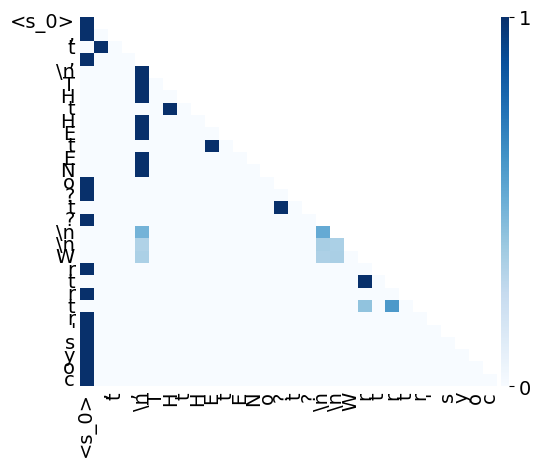

In [127]:
seq_indices = [0]
seq_len = 30
layer_idx = 2
head_idx = 0
plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=14, titles=[], save_files_fn=[], fn=None)

In [128]:
outputs_list[0]['output'][0, :10, :].norm(dim=-1), outputs_list[1]['output'][0, :10, :].norm(dim=-1), outputs_list[2]['attn_logits'][0, 0, :5, :5]

(tensor([227.2108,  31.9702,  17.0428,  31.5581,  40.8134,  43.3120,  43.4924,
          16.3806,  42.6910,  42.9093], device='cuda:2',
        grad_fn=<LinalgVectorNormBackward0>),
 tensor([ 297.7178,   58.3530,   22.5895,   58.0588, 1149.7037,  163.5723,
          151.0066,   37.5304,  149.7832,  253.9182], device='cuda:2',
        grad_fn=<LinalgVectorNormBackward0>),
 tensor([[-1.4507e+01,        -inf,        -inf,        -inf,        -inf],
         [ 1.9615e+01, -4.5188e+00,        -inf,        -inf,        -inf],
         [-2.3228e+01,  2.0803e+01,  4.8797e+00,        -inf,        -inf],
         [ 2.5018e+01, -7.2704e+00, -1.2867e+00, -7.6125e+00,        -inf],
         [ 8.8079e-01,  2.4345e+00,  1.3142e+00,  2.1296e-02,  1.6204e+01]],
        device='cuda:2', grad_fn=<SliceBackward0>))

In [246]:
summary_dynamic_traj_test = {}
for step in tqdm([1000, 5000, 10000]):
    model_loader.change_steps(step)
    summary_test = get_dynamic_summary(ds, x, y, model_loader, hook_dict, keys, probs, triggers_pos)
    summary_dynamic_traj_test[step] = summary_test
steps_list, summary_dynamic_traj_test = concat_summary(summary_dynamic_traj_test, hook_dict, keys)

100%|██████████| 3/3 [00:12<00:00,  4.22s/it]


In [248]:
summary_test['basic']

{'icl_risk': 4.168516170466319e-05,
 'markov_risk': 2.229145050048828,
 'bos_attn': [0.006461598444730043, 0.9940565228462219],
 'output_norm': [135.627197265625, 156.7259521484375, 208.7527313232422],
 'value_norm': [34.295799255371094, 0.7551209330558777],
 'output_state': [[0.394389808177948,
   -0.35230928659439087,
   0.06693512201309204,
   3.4397239685058594,
   -0.7445011138916016,
   -0.6545038819313049,
   -0.21214622259140015,
   0.1594831645488739,
   -1.439387321472168,
   -14.19113540649414,
   -0.59795743227005,
   13.761731147766113,
   0.5814005136489868,
   0.5817804932594299,
   3.088196039199829,
   -2.3489363193511963,
   -0.7229358553886414,
   0.24097441136837006,
   -25.798377990722656,
   -0.1507844179868698,
   -0.0776268020272255,
   1.2168614864349365,
   0.13693757355213165,
   8.067180633544922,
   -0.19386258721351624,
   -1.6868805885314941,
   -3.3166186809539795,
   0.14079168438911438,
   -0.1849047839641571,
   2.846681594848633,
   -0.55246543884277

In [112]:
summary_dynamic_traj = {}
for step in tqdm(torch.arange(0, 1000, 20).tolist() + torch.arange(1000, 100001, 400).tolist()):
    model_loader.change_steps(step)
    summary_dynamic_traj[step] = get_dynamic_summary(ds, x, y, model_loader, hook_dict, keys, probs, triggers_pos)

100%|██████████| 298/298 [14:05<00:00,  2.84s/it]


In [113]:
torch.save(summary_dynamic_traj, f"/data/tianyu/birth/dynamics/model_L3_H1_bos1_delim0/summary_dynamic_traj.pt")
OmegaConf.save(cfg, f"/data/tianyu/birth/dynamics/model_L3_H1_bos1_delim0/config.yaml")

# Start from here if doing re-test

In [10]:
# model_loader.save_dynamic_summary(summary_dynamic_traj)
summary_dynamic_traj = model_loader.load_dynamic_summary()

In [11]:
steps_list, summary_dynamic_cat = concat_summary(summary_dynamic_traj, hook_dict, keys=keys+["norm_influence_grad", "norm_influence_update"], )

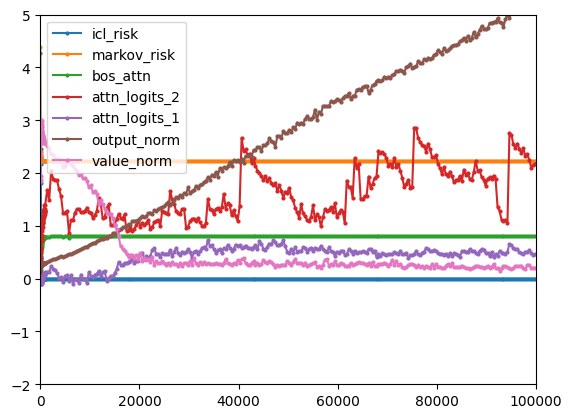

In [12]:
plt.plot(steps_list, summary_dynamic_cat["basic"]["icl_risk"], label="icl_risk", marker = 'o', markersize=2)
plt.plot(steps_list, summary_dynamic_cat["basic"]["markov_risk"], label="markov_risk", marker = 'o', markersize=2)
plt.plot(steps_list, summary_dynamic_cat["basic"]["bos_attn"][:, 2], label="bos_attn", marker = 'o', markersize=2)
plt.plot(steps_list, summary_dynamic_cat["basic"]["attn_logits"][:, 2, 1]/15, label="attn_logits_2", marker = 'o', markersize=2)
plt.plot(steps_list, summary_dynamic_cat["basic"]["attn_logits"][:, 1, 1]/15, label="attn_logits_1", marker = 'o', markersize=2)
plt.plot(steps_list, summary_dynamic_cat["basic"]["output_norm"][:, 0]/100, label="output_norm", marker = 'o', markersize=2)
plt.plot(steps_list, summary_dynamic_cat["basic"]["value_norm"][:, 1]/5, label="value_norm", marker = 'o', markersize=2)
# plt.gca().set_xscale('log')
plt.xlim(0, 100000)
plt.ylim(-2, 5)
plt.legend()
plt.show()

In [14]:
for n, influ in summary_dynamic_cat["basic"]["norm_influence"].items():
    print(n, influ.mean())
for n, influ in summary_dynamic_cat["clean_attn"]["norm_influence"].items():
    print(n, influ.mean())
weights_subset = ['layers.0.attention.wv.weight', 'layers.0.ff.w1.weight', ]

tok_embeddings.weight 0.0017554152012514087
pos_embeddings.weight 0.001755462364028502
layers.0.attention.wq.weight 0.0
layers.0.attention.wk.weight 0.0
layers.0.attention.wv.weight 0.05880103123295371
layers.0.attention.wo.weight 0.004651779896424299
layers.0.ff.w1.weight 0.060109577709324534
layers.0.ff.w2.weight 0.011152557400914672
layers.0.attention_norm.weight 0.001557947507532521
layers.0.attention_norm.bias -0.0014150440257732811
layers.0.ff_norm.weight 0.002490737171677473
layers.0.ff_norm.bias 0.003605522015463701
tok_embeddings.weight -0.003250717578681214
pos_embeddings.weight -0.0032507515516411044
layers.0.attention.wq.weight 0.0
layers.0.attention.wk.weight 0.0
layers.0.attention.wv.weight -0.05731709042467152
layers.0.attention.wo.weight -0.06342163525438546
layers.0.ff.w1.weight -0.5765563135375987
layers.0.ff.w2.weight -0.014921516511314268
layers.0.attention_norm.weight 0.008486974677620824
layers.0.attention_norm.bias 0.05328698790519973
layers.0.ff_norm.weight 0.01

In [166]:
summary_dynamic_cat["basic"]["norm_influence"]['layers.0.ff.w1.weight'][:].mean() * 100000

6010.957770932453

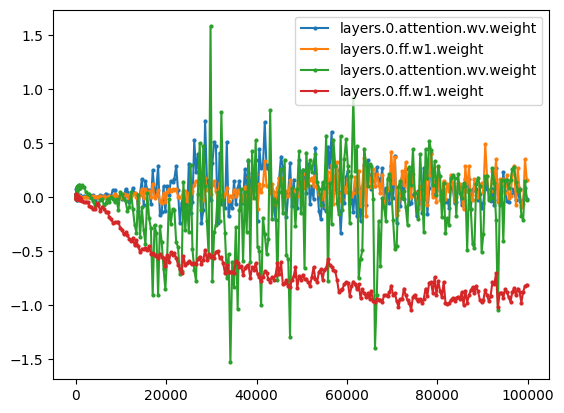

In [15]:
for n, influ in summary_dynamic_cat["basic"]["norm_influence"].items():
    if n in weights_subset:
        plt.plot(steps_list, influ, label=n, marker = 'o', markersize=2)
for n, influ in summary_dynamic_cat["clean_attn"]["norm_influence"].items():
    if n in weights_subset:
        plt.plot(steps_list, influ, label=n, marker = 'o', markersize=2)
plt.legend()
plt.show()

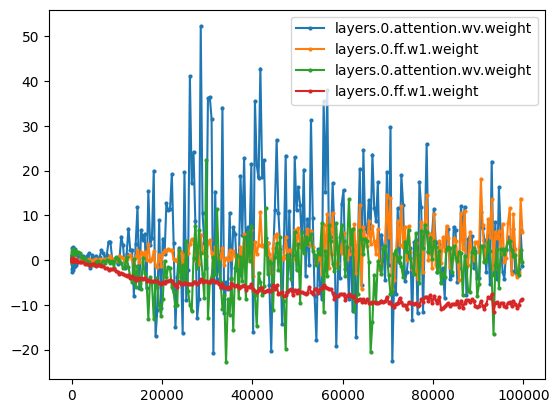

In [16]:
for n, influ in summary_dynamic_cat["basic"]["norm_influence_grad"].items():
    if n in weights_subset:
        plt.plot(steps_list, influ, label=n, marker = 'o', markersize=2)
for n, influ in summary_dynamic_cat["clean_attn"]["norm_influence_grad"].items():
    if n in weights_subset:
        plt.plot(steps_list, influ, label=n, marker = 'o', markersize=2)
plt.legend()
plt.show()

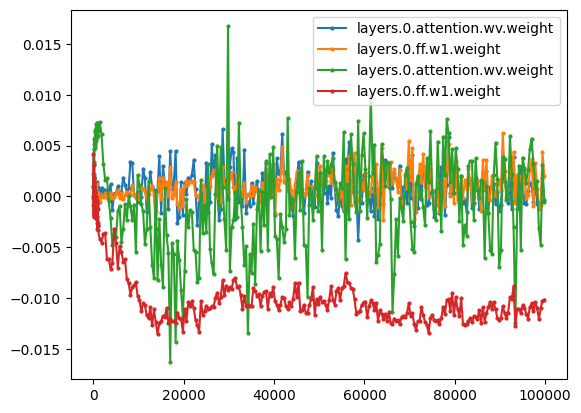

In [17]:
for n, influ in summary_dynamic_cat["basic"]["norm_influence_update"].items():
    if n in weights_subset:
        plt.plot(steps_list, influ, label=n, marker = 'o', markersize=2)
for n, influ in summary_dynamic_cat["clean_attn"]["norm_influence_update"].items():
    if n in weights_subset:
        plt.plot(steps_list, influ, label=n, marker = 'o', markersize=2)
plt.legend()
plt.show()

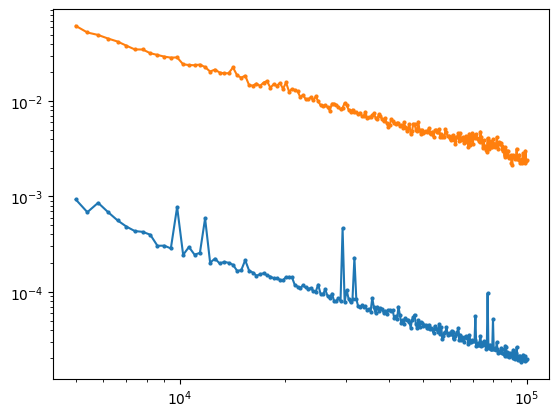

In [18]:
plt.plot(steps_list[60:], summary_dynamic_cat["basic"]["grads_fr"]['layers.0.attention.wv.weight'][60:], marker = 'o', markersize=2)
plt.plot(steps_list[60:], summary_dynamic_cat["clean_attn"]["grads_fr"]['layers.0.attention.wv.weight'][60:], marker = 'o', markersize=2)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

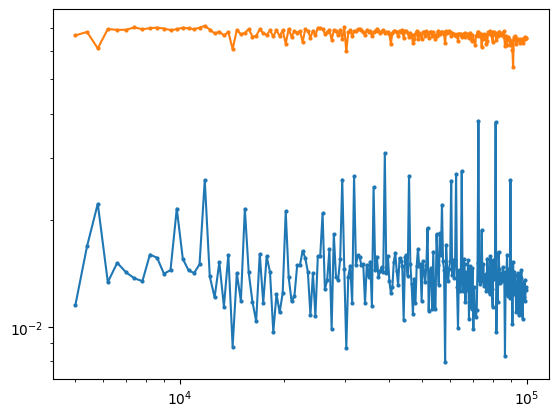

In [19]:
plt.plot(steps_list[60:], summary_dynamic_cat["basic"]["adam_fr"]['layers.0.attention.wv.weight'][60:], marker = 'o', markersize=2)
plt.plot(steps_list[60:], summary_dynamic_cat["clean_attn"]["adam_fr"]['layers.0.attention.wv.weight'][60:], marker = 'o', markersize=2)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

In [215]:
data_x, data_y = steps_list, summary_dynamic_cat["basic"]["output_norm"][:, 0]
coefficients = np.polyfit(data_x, data_y, 1)
print(coefficients)

[5.09886442e-03 2.00195512e+01]


In [188]:
for n, value in summary_dynamic_cat["basic"]["grads_fr"].items():
    log_x = np.log(steps_list[60:])
    log_y = np.log(value[60:])
    coefficients = np.polyfit(log_x, log_y, 1)
    print(n, coefficients)

tok_embeddings.weight [-0.92425113  0.23095157]
pos_embeddings.weight [-0.89171122 -0.22190546]
layers.0.attention.wq.weight [-1.25641554  2.09087706]
layers.0.attention.wk.weight [-1.32709412  2.73608776]
layers.0.attention.wv.weight [-1.20943675  3.10198565]
layers.0.attention.wo.weight [-1.07611652  2.55108945]
layers.0.ff.w1.weight [-1.15474275  4.5208131 ]
layers.0.ff.w2.weight [-0.90900033  2.53421638]
layers.0.attention_norm.weight [-0.46428337 -6.5271536 ]
layers.0.attention_norm.bias [-0.49689971 -4.94121079]
layers.0.ff_norm.weight [-0.75939508 -1.81301292]
layers.0.ff_norm.bias [-0.96589463  0.46248177]
layers.1.attention.wq.weight [-0.92491944 -0.14911934]
layers.1.attention.wk.weight [-0.88615026 -0.35769066]
layers.1.attention.wv.weight [-1.06112904  2.42982803]
layers.1.attention.wo.weight [-1.21708597  3.6924687 ]
layers.1.ff.w1.weight [-0.57461222 -0.86202718]
layers.1.ff.w2.weight [-0.33745945 -2.1741674 ]
layers.1.attention_norm.weight [-0.62587011 -4.29230488]
layer

In [192]:
for n, value in summary_dynamic_cat["clean_attn"]["adam_fr"].items():
    log_x = np.log(steps_list[60:])
    log_y = np.log(value[60:])
    coefficients = np.polyfit(log_x, log_y, 1)
    print(n, coefficients)

tok_embeddings.weight [ 0.0616939  -4.26289648]
pos_embeddings.weight [ 0.05770122 -3.62409977]
layers.0.attention.wq.weight [ 0.08705746 -3.84717228]
layers.0.attention.wk.weight [ 0.0115523  -3.05909769]
layers.0.attention.wv.weight [-0.01926761 -2.49998904]
layers.0.attention.wo.weight [-0.02987911 -2.39811094]
layers.0.ff.w1.weight [-0.08883441 -1.31252721]
layers.0.ff.w2.weight [-0.15459435 -0.53385552]
layers.0.attention_norm.weight [ 0.01990892 -5.62819944]
layers.0.attention_norm.bias [ 0.02899455 -5.68275801]
layers.0.ff_norm.weight [ 0.05662912 -6.01177351]
layers.0.ff_norm.bias [ 0.00632844 -5.46089741]
layers.1.attention.wq.weight [ 0.07420503 -3.96676814]
layers.1.attention.wk.weight [ 0.06176881 -3.92404801]
layers.1.attention.wv.weight [-0.00891394 -2.64671497]
layers.1.attention.wo.weight [-0.00601361 -2.66436246]
layers.1.ff.w1.weight [-0.07765073 -1.40840032]
layers.1.ff.w2.weight [-0.12474078 -0.8962772 ]
layers.1.attention_norm.weight [ 0.01770032 -5.88947403]
layer

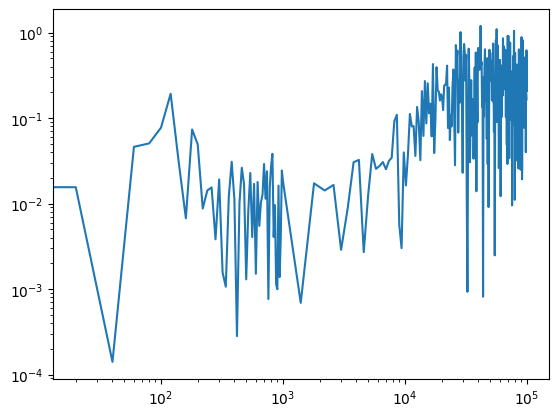

In [226]:
plt.plot(steps_list, np.abs(np.stack(list(summary_dynamic_cat["basic"]["norm_influence"].values())).sum(axis=0)))
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

In [195]:
np.stack(list(summary_dynamic_cat["basic"]["norm_influence"].values())).sum(axis=0).mean()

0.14446498647379755

In [168]:
for n, influ in summary_dynamic_cat["clean_attn"]["norm_influence"].items():
    print(n, influ.mean())

tok_embeddings.weight -0.003250717578681214
pos_embeddings.weight -0.0032507515516411044
layers.0.attention.wq.weight 0.0
layers.0.attention.wk.weight 0.0
layers.0.attention.wv.weight -0.05731709042467152
layers.0.attention.wo.weight -0.06342163525438546
layers.0.ff.w1.weight -0.5765563135375987
layers.0.ff.w2.weight -0.014921516511314268
layers.0.attention_norm.weight 0.008486974677620824
layers.0.attention_norm.bias 0.05328698790519973
layers.0.ff_norm.weight 0.013118627090610874
layers.0.ff_norm.bias 0.006610597562964218


In [220]:
for n, influ in summary_dynamic_cat["clean_attn"]["norm_influence"].items():
    print(n, influ.mean())

tok_embeddings.weight -0.003250717578681214
pos_embeddings.weight -0.0032507515516411044
layers.0.attention.wq.weight 0.0
layers.0.attention.wk.weight 0.0
layers.0.attention.wv.weight -0.05731709042467152
layers.0.attention.wo.weight -0.06342163525438546
layers.0.ff.w1.weight -0.5765563135375987
layers.0.ff.w2.weight -0.014921516511314268
layers.0.attention_norm.weight 0.008486974677620824
layers.0.attention_norm.bias 0.05328698790519973
layers.0.ff_norm.weight 0.013118627090610874
layers.0.ff_norm.bias 0.006610597562964218
